# Winequality dataset

## Feim els imports

In [1]:
#IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression, RFE

from feature_engine.creation import MathematicalCombination, CombineWithReferenceFeature

## Preparam el dataset

Funció que separa les features i les etiquetes, escalant les dades

In [2]:
def load_data(df):
    y=df.quality
    X=df.drop('quality',axis=1)
    X = min_max_scaler.fit_transform(X)
    return X, y

Carregam els datasets a dos dataframes a partir dels fitxers csv: winequality-red.csv i winequality-white.csv

Afegim una nova columna que indiqui el tipus de vi a cada dataset i juntam els dos datasets en un de nou

In [3]:
#CREATE AND MERGE DATAFRAMES
dfRed=pd.read_csv("winequality-red.csv", sep=";")
dfWhite=pd.read_csv("winequality-white.csv", sep=";")

dfRed['type']="Red"
dfWhite['type']="White"
df = pd.concat([dfRed,dfWhite])

Consultam les files del dataframe amb valors absents i les eliminam

In [4]:
df[df.isna().any(axis=1)]
df.dropna(inplace=True)

Convertim la columna quality en una columna de valors categòrics

In [5]:
dfAux=df.copy()
df.loc[dfAux['quality'] < 6, 'quality'] = "Baixa"
df.loc[dfAux['quality'] == 6, 'quality'] = "Mitjana"
df.loc[dfAux['quality'] > 6, 'quality'] = "Alta"
del dfAux

Convertim els valors categòrics en númerics

In [6]:
labelencoder = preprocessing.LabelEncoder()

df['type']=labelencoder.fit_transform(df['type'])
df['quality']=labelencoder.fit_transform(df['quality'])

Recolocam les columnes

In [7]:
df = df.reindex(columns=['fixed acidity', 'volatile acidity', 'citric acid', 
                       'residual sugar', 'chlorides', 'free sulfur dioxide',
                       'total sulfur dioxide', 'density', 'pH', 'sulphates', 
                       'alcohol', 'type', 'quality'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  type                  6497 non-null   int32  
 12  quality               6497 non-null   int32  
dtypes: float64(11), int32(2)
memory usage: 659.9 KB


In [9]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,2
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,1


Mesclam el dataframe i carregam les dades a les variables *features* (característiques) i *labels* (etiquetes)

In [10]:
min_max_scaler = preprocessing.MinMaxScaler()
df = df.sample(frac=1)

features, labels = load_data(df)

### Separació del conjunt d'entrenament i el de test
Per separar les dades en els conjunts d'entrenament i de test hem emprat la funció train_test_split

Hem decidit emprar un 80% entrenament i un 20% de test ja que  amb un valor més baix d'entrenament el model de regressió logistica i el del perceptró presentaven underfiting 


In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Visualització de les dades

Aquí podem observar les correlacions entre els distints atributs

<AxesSubplot:>

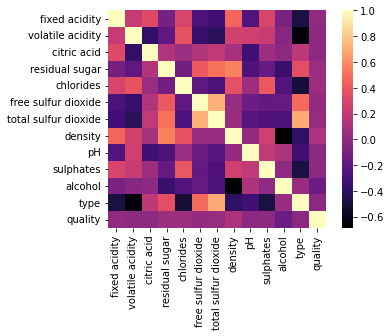

In [12]:
corr = df.corr() #Abs?

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        square=True,
        cmap="magma")


Graficam el valor que prenen les característiques númeriques del dataframe mitjançant un histograma

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

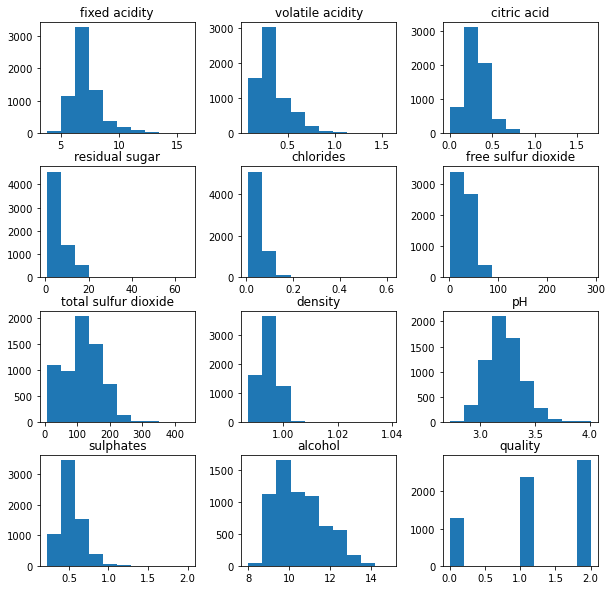

In [13]:
df.drop("type", axis=1).hist(figsize=(10,10), grid=False)

Gràfic cirular amb el que podem veure la proporció de vi blanc i vermell

1    75.388641
0    24.611359
Name: type, dtype: float64


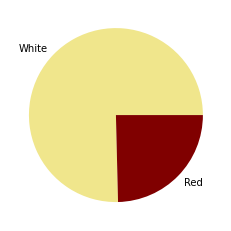

In [14]:
plt.pie(df['type'].value_counts(), labels = ["White","Red"], colors=["khaki","Maroon"])
print(df['type'].value_counts(normalize=True)*100)

# **Classificadors**

Per a cada model imprimim el seu classification report, la precisió de training i la de testing. A més, guardam aquests dos valors dins dos dataframes externs per a després poder comparar les modificacions que farem al dataframe original

Hem decidit fer els models dins funcions per poder cridar-les des de l'apartat de [Enginyeria de característiques/Proves](#Proves) fora haver de reescriure el codi.

In [15]:
dfTrainAccuracy = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])
dfTestAccuracy = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])

## Regressió Logística

Hem decidit donar-li valor al hiperparàmetre max_iters perquè amb el valor per defecte no arribava a convergir.

In [16]:
def RegressioLogisitca(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    logreg = LogisticRegression(max_iter=5000)
    logreg.fit(X_train,y_train)

    y_predict = logreg.predict(X_test)
    

    print("\nRegressio Logísitca:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = logreg.score(X_train,y_train)
    testing_accuracy = logreg.score(X_test,y_test)
    
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Regressió Logística']=training_accuracy*100
    dfTestAccuracy.at[nom,'Regressió Logística']=testing_accuracy*100 
    
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=logreg.classes_), display_labels=logreg.classes_).plot()
    
    plt.show()

RegressioLogisitca(df, "Original")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.57      0.28      0.38       253
           1       0.66      0.64      0.65       476
           2       0.54      0.66      0.59       571

    accuracy                           0.58      1300
   macro avg       0.59      0.53      0.54      1300
weighted avg       0.59      0.58      0.57      1300

training_accuracy: 57.667885318452946
testing_accuracy: 58.30769230769231


## Perceptró

In [17]:
def Perceptro(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    perceptro = Perceptron()
    perceptro.fit(X_train,y_train)

    y_predict = perceptro.predict(X_test)
    
    print("\nPerceptró:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = perceptro.score(X_train,y_train)
    testing_accuracy = perceptro.score(X_test,y_test)
    
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Perceptró']=training_accuracy*100
    dfTestAccuracy.at[nom,'Perceptró']=testing_accuracy*100 
    
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=perceptro.classes_), display_labels=perceptro.classes_).plot()
    
    plt.show()

Perceptro(df, "Original")


Perceptró:
              precision    recall  f1-score   support

           0       0.44      0.55      0.49       253
           1       0.79      0.14      0.24       476
           2       0.46      0.72      0.56       571

    accuracy                           0.47      1300
   macro avg       0.56      0.47      0.43      1300
weighted avg       0.57      0.47      0.43      1300

training_accuracy: 48.66269001346931
testing_accuracy: 47.30769230769231


## Random Forest

Hem decidit donar-li valor al hiperparàmetre max_depth perquè amb el valor per defecte teniem overfitting.

In [18]:
def RandomForest(df, nom):
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    rf = RandomForestClassifier(max_depth=14)
    rf.fit(X_train, y_train)

    y_predict=rf.predict(X_test)

    print("\nRandom Forest:")
    print(classification_report(y_test, y_predict,zero_division=1))
    
    training_accuracy = rf.score(X_train,y_train)
    testing_accuracy = rf.score(X_test,y_test)
    
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Random Forest']=training_accuracy*100
    dfTestAccuracy.at[nom,'Random Forest']=testing_accuracy*100
    
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=rf.classes_), display_labels=rf.classes_).plot()  
    plt.show()
           
RandomForest(df, "Original")


Random Forest:
              precision    recall  f1-score   support

           0       0.73      0.56      0.63       253
           1       0.75      0.77      0.76       476
           2       0.67      0.72      0.69       571

    accuracy                           0.71      1300
   macro avg       0.71      0.68      0.69      1300
weighted avg       0.71      0.71      0.70      1300

training_accuracy: 98.61458533769482
testing_accuracy: 70.61538461538461


## Conclusions


Blablabla

# **Enginyeria de característiques**

L'enginyeria de característiques (feature engineering) és el procés de selecció, extracció, creació i transformació de les característiques d'un dataset amb l'objectiu de millorar l'eficacia d'un model predictiu.

Per a dur a terme l'enginyeria de característiques nosaltres hem duit a terme els següents apartats: 
- **Feature importances dels models**: Ens permet saber la importancia de cada característica dins cada model amb el fi de després eliminar les característiques menys importants
- **Correlacions màximes i mínimes**: Ens permet saber quines caracterísitiques tenen major correlació entre elles. També ens permet saber quines caracteístiques tenen menys correlació amb la qualitat del vi per després poder eliminarles
- **Feature Selection**: Selecció de les característiques més i menys importantes. Nosaltres implementarem els:
   1. Sequential Feature Selection
   2. Univariate Feature Selection amb Kbest
   3. Recursive Feature Elimination

## Feature importances de cada model

In [19]:
dfWquality=df.drop("quality", axis=1)

### Regressió logística <a id='Regressio-Logistica'></a>

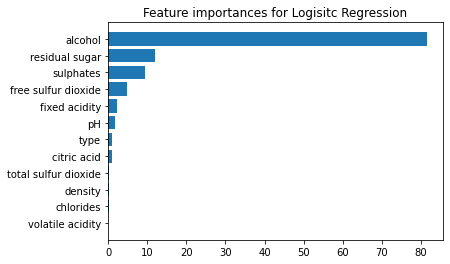

In [20]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train,y_train)

logreg_odds = np.exp(logreg.coef_[0])
indices=np.argsort(logreg_odds)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Logisitc Regression")
ax.barh(range(len(logreg_odds)), logreg_odds[indices])
ax.set_yticks(range(len(logreg_odds)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

### Perceptró <a id='Perceptro'></a>

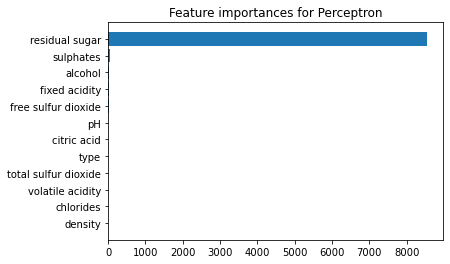

In [21]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

perceptron_odds = np.exp(perceptron.coef_[0])
indices=np.argsort(perceptron_odds)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Perceptron")
ax.barh(range(len(perceptron_odds)), perceptron_odds[indices])
ax.set_yticks(range(len(perceptron_odds)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

### Random Forest <a id='Random-Forest'></a>

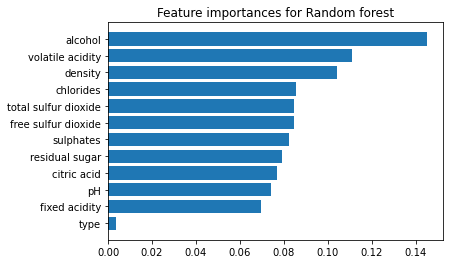

In [22]:
rf = RandomForestClassifier(max_depth=14)
rf.fit(X_train, y_train)

importancesRF = rf.feature_importances_
indices = np.argsort(importancesRF)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Random forest")
ax.barh(range(len(importancesRF)), importancesRF[indices])
ax.set_yticks(range(len(importancesRF)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

### 
| Model | Millor característica | Pitjor característica |
| ----------- | ----------- | ----------- |
| Regressió Logística | Alcohol | Volatile Acidity |
| Perceptró | Residual Sugar | Density |
| Random Forest | Alcohol | Type |



## Correlacions màximes i mínimes <a id='Correlacions-Minimes'></a>

In [23]:
c = df.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

print(so[13:23]) #Les 12 primeres son autocorrelacions
print("-------------")
print(so['quality'][8:13])


total sulfur dioxide  free sulfur dioxide     0.720934
free sulfur dioxide   total sulfur dioxide    0.720934
type                  total sulfur dioxide    0.700357
total sulfur dioxide  type                    0.700357
alcohol               density                 0.686745
density               alcohol                 0.686745
volatile acidity      type                    0.653036
type                  volatile acidity        0.653036
density               residual sugar          0.552517
residual sugar        density                 0.552517
dtype: float64
-------------
free sulfur dioxide    0.013004
sulphates              0.012841
volatile acidity       0.010716
fixed acidity          0.009013
citric acid            0.008921
dtype: float64


Les característiques amb major correlació son el *Free sulfur dioxide* i el *Total sulfur dioxide*\
Les característiques amb menor correlació amb la qualitat son el *citric acids*, *fixed acidity* i *volatile acidity*

## [Feature Selection](https://www.scikit-learn.org/stable/modules/feature_selection.html)

### [Sequential Feature Selector](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py) <a id='Sequential-Feature-Selector'></a>


In [24]:
feature_names = np.array(dfWquality.columns)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)

In [25]:
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=10, direction="forward"
).fit(X_train, y_train)


sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=10, direction="backward"
).fit(X_train, y_train)


print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
    "\nFeatures not selected by forward sequential selection: "
    f"{dfWquality.columns.difference(feature_names[sfs_forward.get_support()])}\n"
)

print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
    "\nFeatures not selected by forward sequential selection: "
    f"{dfWquality.columns.difference(feature_names[sfs_backward.get_support()])}"
)

Features selected by forward sequential selection: ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density'
 'sulphates' 'alcohol']
Features not selected by forward sequential selection: Index(['pH', 'type'], dtype='object')

Features selected by backward sequential selection: ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH' 'sulphates'
 'type']
Features not selected by forward sequential selection: Index(['alcohol', 'chlorides'], dtype='object')


### [Univariate Feature selection with Kbest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html#sklearn.feature_selection.GenericUnivariateSelect) <a id='Univariate-feature-selection'></a> 


In [26]:
mask = SelectKBest(f_regression, k=10).fit(X_train, y_train).get_support()
best_features = dfWquality.columns[mask]
worst_features = dfWquality.columns.difference(best_features)
print("Best features", best_features)
print("Worst features", worst_features)


Best features Index(['volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates',
       'alcohol', 'type'],
      dtype='object')
Worst features Index(['fixed acidity', 'pH'], dtype='object')


### [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) <a id='Recursive-feature-elimination'></a> 


In [27]:
feature_names = np.array(dfWquality.columns)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)

In [28]:
rfe_selector = RFE(ridge, n_features_to_select=10).fit(X_train, y_train)

print(
    "Features selected by recursive feature elimination: "
    f"{feature_names[rfe_selector.get_support()]}"
    "\nFeatures not selected by recursive feature elimination: "
    f"{dfWquality.columns.difference(feature_names[rfe_selector.get_support()])}\n"
)

Features selected by recursive feature elimination: ['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'total sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol']
Features not selected by recursive feature elimination: Index(['free sulfur dioxide', 'type'], dtype='object')



### 
| Tipus | 1ra Pitjor Caract. | 2na Pitjor Caract. |
| ----------- | ----------- | ----------- |
| Sequential Feature Selection - Forward | Free sulfur dioxide | Total sulfur dioxide |
| Sequential Feature Selection - Backward | Alcohol | Total sulfur dioxide |
| Univariate Feature Selection | Citric Acid | Type |
| Recursive Feature Elimination | Alcohol | Free sulfur dioxide |

Els resultats poden variar depenent de la execució, aquests valors son els obtinguts a una execució

## Proves <a id='Proves'></a>

### Eliminam features

#### Fora volatile acidity

Provam de llevar la característica de la *volatile acidity* ja que com hem vist [aquí](#Regressio-Logistica), el Feature Selection de la Regressio Logístic ens diu que és la característica amb menys importancia

In [29]:
dfWvolatile_acidity = df.drop('volatile acidity',axis=1)

RegressioLogisitca(dfWvolatile_acidity, "Fora volatile acidity")
Perceptro(dfWvolatile_acidity, "Fora volatile acidity")
RandomForest(dfWvolatile_acidity, "Fora volatile acidity")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.56      0.28      0.37       253
           1       0.62      0.66      0.64       476
           2       0.53      0.63      0.58       571

    accuracy                           0.57      1300
   macro avg       0.57      0.52      0.53      1300
weighted avg       0.57      0.57      0.56      1300

training_accuracy: 56.39792187800654
testing_accuracy: 56.92307692307692

Perceptró:
              precision    recall  f1-score   support

           0       0.25      0.00      0.01       253
           1       1.00      0.00      0.00       476
           2       0.44      0.99      0.61       571

    accuracy                           0.44      1300
   macro avg       0.56      0.33      0.21      1300
weighted avg       0.61      0.44      0.27      1300

training_accuracy: 43.544352511064076
testing_accuracy: 43.769230769230774

Random Forest:
              precision    recall  f1-sc

#### Fora density

Provam de llevar la característica de *density* ja que com hem vist [aquí](#Perceptro), el Feature Selection del Perceptro ens diu que és la característica amb menys importancia

In [30]:
dfWdensity = df.drop('density',axis=1)

RegressioLogisitca(dfWdensity, "Fora density")
Perceptro(dfWdensity, "Fora density")
RandomForest(dfWdensity, "Fora density")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.58      0.28      0.38       253
           1       0.66      0.64      0.65       476
           2       0.54      0.66      0.59       571

    accuracy                           0.58      1300
   macro avg       0.59      0.53      0.54      1300
weighted avg       0.59      0.58      0.57      1300

training_accuracy: 57.706369059072536
testing_accuracy: 58.30769230769231

Perceptró:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       253
           1       0.72      0.19      0.30       476
           2       0.46      0.94      0.62       571

    accuracy                           0.48      1300
   macro avg       0.39      0.38      0.31      1300
weighted avg       0.47      0.48      0.38      1300

training_accuracy: 49.85568597267655
testing_accuracy: 48.23076923076923

Random Forest:
              precision    recall  f1-sco

#### Fora type

Provam de llevar la característica de *type* ja que com hem vist [aquí](#Random-Forest), el Feature Selection del Random Forest ens diu que és la característica amb menys importancia

In [31]:
dfWtype = df.drop('type',axis=1)

RegressioLogisitca(dfWtype, "Fora type")
Perceptro(dfWtype, "Fora type")
RandomForest(dfWtype, "Fora type")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.57      0.29      0.38       253
           1       0.65      0.65      0.65       476
           2       0.54      0.66      0.59       571

    accuracy                           0.58      1300
   macro avg       0.59      0.53      0.54      1300
weighted avg       0.59      0.58      0.57      1300

training_accuracy: 57.610159707523565
testing_accuracy: 58.23076923076923

Perceptró:
              precision    recall  f1-score   support

           0       0.27      0.93      0.42       253
           1       0.71      0.32      0.44       476
           2       0.43      0.17      0.24       571

    accuracy                           0.37      1300
   macro avg       0.47      0.47      0.37      1300
weighted avg       0.50      0.37      0.35      1300

training_accuracy: 38.5607081008274
testing_accuracy: 37.230769230769226

Random Forest:
              precision    recall  f1-sco

#### Fora citric acid, fixed acidity i volatile acidity

Provam de llevar les característiques del *citric acid, fixed acidity i volatile acidity* ja que com hem vist [aquí](#Correlacions-Minimes), son les tres característiques menys correlacionades amb la qualitat.

In [32]:
dfWCA_FA_VA = df.drop('citric acid',axis=1)
dfWCA_FA_VA = dfWCA_FA_VA.drop('volatile acidity',axis=1)
dfWCA_FA_VA = dfWCA_FA_VA.drop('fixed acidity',axis=1)

RegressioLogisitca(dfWCA_FA_VA, "Fora CitricAc_FixedAc_VolatileAc")
Perceptro(dfWCA_FA_VA, "Fora CitricAc_FixedAc_VolatileAc")
RandomForest(dfWCA_FA_VA, "Fora CitricAc_FixedAc_VolatileAc")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.56      0.28      0.38       253
           1       0.62      0.65      0.63       476
           2       0.53      0.62      0.57       571

    accuracy                           0.57      1300
   macro avg       0.57      0.52      0.53      1300
weighted avg       0.57      0.57      0.56      1300

training_accuracy: 56.8404848951318
testing_accuracy: 56.61538461538461

Perceptró:
              precision    recall  f1-score   support

           0       0.33      0.00      0.01       253
           1       0.71      0.23      0.35       476
           2       0.46      0.92      0.62       571

    accuracy                           0.49      1300
   macro avg       0.50      0.39      0.32      1300
weighted avg       0.53      0.49      0.40      1300

training_accuracy: 49.39388108524149
testing_accuracy: 49.15384615384615

Random Forest:
              precision    recall  f1-score

#### Fora free sulfur dioxide i total sulfur dioxide

Provam de llevar les característiques del *free and total sulfur dioxide acid* ja que com hem vist [aquí](#Sequential-Feature-Selector), ja que el Forward Feature Selection ens ha dit que son les dues pitjors característiques 

In [33]:
dfWSO2 = df.drop('free sulfur dioxide',axis=1)
dfWSO2 = dfWSO2.drop('total sulfur dioxide',axis=1)

RegressioLogisitca(dfWSO2, "Fora SO2")
Perceptro(dfWSO2, "Fora SO2")
RandomForest(dfWSO2, "Fora SO2")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.56      0.28      0.37       253
           1       0.65      0.63      0.64       476
           2       0.53      0.65      0.58       571

    accuracy                           0.57      1300
   macro avg       0.58      0.52      0.53      1300
weighted avg       0.58      0.57      0.56      1300

training_accuracy: 57.167596690398305
testing_accuracy: 57.230769230769226

Perceptró:
              precision    recall  f1-score   support

           0       0.65      0.05      0.10       253
           1       0.74      0.27      0.40       476
           2       0.47      0.91      0.62       571

    accuracy                           0.51      1300
   macro avg       0.62      0.41      0.37      1300
weighted avg       0.60      0.51      0.44      1300

training_accuracy: 51.414277467769864
testing_accuracy: 51.07692307692307

Random Forest:
              precision    recall  f1-s

#### Fora alcohol i total sulfur dioxide

Provam de llevar les característiques del *alcohol i total SO2* ja que com hem vist [aquí](#Sequential-Feature-Selector), el Backward Feature Selection ens ha dit que son les dues pitjors característiques 

In [34]:
dfWalcohol_totalSO2 = df.drop('alcohol',axis=1)
dfWalcohol_totalSO2 = dfWalcohol_totalSO2.drop('total sulfur dioxide',axis=1)

RegressioLogisitca(dfWalcohol_totalSO2, "Fora alcohol_totalSO2")
Perceptro(dfWalcohol_totalSO2, "Fora alcohol_totalSO2")
RandomForest(dfWalcohol_totalSO2, "Fora alcohol_totalSO2")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.83      0.04      0.08       253
           1       0.62      0.51      0.56       476
           2       0.49      0.77      0.60       571

    accuracy                           0.53      1300
   macro avg       0.65      0.44      0.41      1300
weighted avg       0.61      0.53      0.48      1300

training_accuracy: 53.9349624783529
testing_accuracy: 53.46153846153846

Perceptró:
              precision    recall  f1-score   support

           0       0.64      0.09      0.16       253
           1       0.90      0.02      0.04       476
           2       0.44      0.98      0.61       571

    accuracy                           0.45      1300
   macro avg       0.66      0.36      0.27      1300
weighted avg       0.65      0.45      0.31      1300

training_accuracy: 44.660380989032134
testing_accuracy: 45.38461538461539

Random Forest:
              precision    recall  f1-scor

#### Fora citric acid i type

Provam de llevar les característiques de l'àcid cítric i el type ja que com hem vist [aquí](Univariate-feature-selection), el SelectKBest ens ha dit que son les dues pitjors característiques 

In [35]:
dfWCA_Type = df.drop('citric acid',axis=1)
dfWCA_Type = dfWCA_Type.drop('type',axis=1)

RegressioLogisitca(dfWCA_Type, "Fora CA_Type")
Perceptro(dfWCA_Type, "Fora CA_Type")
RandomForest(dfWCA_Type, "Fora CA_Type")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.59      0.30      0.39       253
           1       0.65      0.64      0.64       476
           2       0.54      0.66      0.59       571

    accuracy                           0.58      1300
   macro avg       0.59      0.53      0.54      1300
weighted avg       0.59      0.58      0.57      1300

training_accuracy: 57.667885318452946
testing_accuracy: 58.23076923076923

Perceptró:
              precision    recall  f1-score   support

           0       0.64      0.11      0.18       253
           1       0.92      0.03      0.05       476
           2       0.45      0.98      0.61       571

    accuracy                           0.46      1300
   macro avg       0.67      0.37      0.28      1300
weighted avg       0.66      0.46      0.32      1300

training_accuracy: 45.295362709255336
testing_accuracy: 45.84615384615385

Random Forest:
              precision    recall  f1-sc

#### Fora alochol i free sulfur dioxide

Provam de llevar les característiques del *alochol i free sulfur dioxide* ja que com hem vist [aquí](#Recursive-feature-elimination), el Recursive Feature Elimination ens ha dit que son les dues pitjors característiques 

In [36]:
dfWalcohol_freeSO2 = df.drop('alcohol',axis=1)
dfWalcohol_freeSO2 = dfWalcohol_freeSO2.drop('free sulfur dioxide',axis=1)

RegressioLogisitca(dfWalcohol_freeSO2, "Fora alcohol_freeSO2")
Perceptro(dfWalcohol_freeSO2, "Fora alcohol_freeSO2")
RandomForest(dfWalcohol_freeSO2, "Fora alcohol_freeSO2")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.70      0.06      0.12       253
           1       0.63      0.57      0.60       476
           2       0.51      0.76      0.61       571

    accuracy                           0.55      1300
   macro avg       0.61      0.46      0.44      1300
weighted avg       0.59      0.55      0.51      1300

training_accuracy: 54.185106792380225
testing_accuracy: 55.230769230769226

Perceptró:
              precision    recall  f1-score   support

           0       0.41      0.72      0.52       253
           1       0.88      0.03      0.06       476
           2       0.42      0.62      0.50       571

    accuracy                           0.42      1300
   macro avg       0.57      0.46      0.36      1300
weighted avg       0.59      0.42      0.34      1300

training_accuracy: 42.793919568982105
testing_accuracy: 42.30769230769231

Random Forest:
              precision    recall  f1-s

### Cream features

#### Acids totals

In [37]:
combinator_Acid_Tot = MathematicalCombination(
    variables_to_combine=['fixed acidity', 'volatile acidity'],
    math_operations = ['sum'],
    new_variables_names = ['total_acidity']
)

df_Acid_Tot = combinator_Acid_Tot.fit_transform(df)

RegressioLogisitca(df_Acid_Tot, "Acid Totals")
Perceptro(df_Acid_Tot, "Acid Totals")
RandomForest(df_Acid_Tot, "Acid Totals")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.57      0.28      0.38       253
           1       0.66      0.65      0.65       476
           2       0.54      0.66      0.59       571

    accuracy                           0.58      1300
   macro avg       0.59      0.53      0.54      1300
weighted avg       0.59      0.58      0.57      1300

training_accuracy: 57.667885318452946
testing_accuracy: 58.38461538461538

Perceptró:
              precision    recall  f1-score   support

           0       0.53      0.37      0.43       253
           1       0.54      0.82      0.65       476
           2       0.54      0.39      0.45       571

    accuracy                           0.54      1300
   macro avg       0.54      0.52      0.51      1300
weighted avg       0.54      0.54      0.52      1300

training_accuracy: 55.12795843756013
testing_accuracy: 54.0

Random Forest:
              precision    recall  f1-score   support


#### Percentatge de Acid cítric respecte a l'acidesa fixada

In [38]:
combinator_PercAC = CombineWithReferenceFeature(
    variables_to_combine=['citric acid'],
    reference_variables=['fixed acidity'],
    operations=['div'],   
    new_variables_names=['percentage_citric_acid'])

df_PercAC = combinator_PercAC.fit_transform(df)

RegressioLogisitca(df_PercAC, "Perc. acid citric")
Perceptro(df_PercAC, "Perc. acid citric")
RandomForest(df_PercAC, "Perc. acid citric")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.57      0.28      0.38       253
           1       0.65      0.64      0.65       476
           2       0.53      0.66      0.59       571

    accuracy                           0.58      1300
   macro avg       0.59      0.53      0.54      1300
weighted avg       0.59      0.58      0.57      1300

training_accuracy: 57.91802963248027
testing_accuracy: 58.15384615384615

Perceptró:
              precision    recall  f1-score   support

           0       0.50      0.01      0.02       253
           1       0.64      0.57      0.60       476
           2       0.49      0.76      0.60       571

    accuracy                           0.54      1300
   macro avg       0.55      0.44      0.41      1300
weighted avg       0.55      0.54      0.49      1300

training_accuracy: 54.51221858764672
testing_accuracy: 54.230769230769226

Random Forest:
              precision    recall  f1-sco

#### Minerals totals

In [39]:
combinator_Minerals_Totals = MathematicalCombination(
    variables_to_combine=['chlorides', 'sulphates'],
    math_operations = ['sum'],
    new_variables_names = ['total_minerals']
)

df_Minerals_Totals = combinator_Minerals_Totals.fit_transform(df)

RegressioLogisitca(df_Minerals_Totals, "Minerals totals")
Perceptro(df_Minerals_Totals, "Minerals totals")
RandomForest(df_Minerals_Totals, "Minerals totals")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.58      0.28      0.38       253
           1       0.66      0.65      0.65       476
           2       0.54      0.67      0.59       571

    accuracy                           0.58      1300
   macro avg       0.59      0.53      0.54      1300
weighted avg       0.59      0.58      0.57      1300

training_accuracy: 57.744852799692126
testing_accuracy: 58.46153846153847

Perceptró:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       253
           1       0.89      0.02      0.03       476
           2       0.44      1.00      0.61       571

    accuracy                           0.44      1300
   macro avg       0.78      0.34      0.22      1300
weighted avg       0.71      0.44      0.28      1300

training_accuracy: 44.27554358283625
testing_accuracy: 44.46153846153847

Random Forest:
              precision    recall  f1-sco

#### Percentatge de Diòxid de sofre lliure

In [40]:
combinator_PercSO2 = CombineWithReferenceFeature(
    variables_to_combine=['free sulfur dioxide'],
    reference_variables=['total sulfur dioxide'],
    operations=['div'],   
    new_variables_names=['percentage_free_sulfur'])

df_PercSO2 = combinator_PercSO2.fit_transform(df)

RegressioLogisitca(df_PercSO2, "Perc. SO2 lliure")
Perceptro(df_PercSO2, "Perc. SO2 lliure")
RandomForest(df_PercSO2, "Perc. SO2 lliure")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.59      0.30      0.40       253
           1       0.65      0.64      0.64       476
           2       0.53      0.66      0.59       571

    accuracy                           0.58      1300
   macro avg       0.59      0.53      0.55      1300
weighted avg       0.59      0.58      0.57      1300

training_accuracy: 58.283625168366356
testing_accuracy: 58.23076923076923

Perceptró:
              precision    recall  f1-score   support

           0       0.33      0.65      0.44       253
           1       0.64      0.65      0.65       476
           2       0.53      0.29      0.38       571

    accuracy                           0.49      1300
   macro avg       0.50      0.53      0.49      1300
weighted avg       0.53      0.49      0.49      1300

training_accuracy: 51.79911487396575
testing_accuracy: 49.38461538461538

Random Forest:
              precision    recall  f1-sco

#### Diòxid de sofre no lliure

In [41]:
combinator_No_FreeSO2 = CombineWithReferenceFeature(
    variables_to_combine=['total sulfur dioxide'],
    reference_variables=['free sulfur dioxide'],
    operations=['sub'],
    new_variables_names=['non_free_sulfur_dioxide']
)

df_No_FreeSO2 = combinator_No_FreeSO2.fit_transform(df)

RegressioLogisitca(df_No_FreeSO2, "S02 no lliure")
Perceptro(df_No_FreeSO2, "S02 no lliure")
RandomForest(df_No_FreeSO2, "S02 no lliure")



Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.57      0.28      0.38       253
           1       0.66      0.64      0.65       476
           2       0.54      0.66      0.59       571

    accuracy                           0.58      1300
   macro avg       0.59      0.53      0.54      1300
weighted avg       0.59      0.58      0.57      1300

training_accuracy: 57.725610929382334
testing_accuracy: 58.23076923076923

Perceptró:
              precision    recall  f1-score   support

           0       0.47      0.24      0.32       253
           1       0.76      0.04      0.08       476
           2       0.44      0.89      0.59       571

    accuracy                           0.45      1300
   macro avg       0.56      0.39      0.33      1300
weighted avg       0.57      0.45      0.35      1300

training_accuracy: 45.7379257263806
testing_accuracy: 45.230769230769226

Random Forest:
              precision    recall  f1-sco

#### Dels diòxid de sofre quin percentatge és una sal

In [42]:
combinator_Sulfurs_Sals = CombineWithReferenceFeature(
    variables_to_combine=['sulphates'],
    reference_variables=['free sulfur dioxide'],
    operations=['div'],
    new_variables_names=['percentage_salt_sulfur']
)

df_Sulfurs_Sals = combinator_Sulfurs_Sals.fit_transform(df)

RegressioLogisitca(df_Sulfurs_Sals, "Sulfurs Sals")
Perceptro(df_Sulfurs_Sals, "Sulfurs Sals")
RandomForest(df_Sulfurs_Sals, "Sulfurs Sals")



Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.57      0.29      0.38       253
           1       0.65      0.64      0.65       476
           2       0.54      0.66      0.59       571

    accuracy                           0.58      1300
   macro avg       0.59      0.53      0.54      1300
weighted avg       0.59      0.58      0.57      1300

training_accuracy: 57.80257841062151
testing_accuracy: 58.23076923076923

Perceptró:
              precision    recall  f1-score   support

           0       0.36      0.69      0.47       253
           1       0.78      0.13      0.23       476
           2       0.43      0.55      0.49       571

    accuracy                           0.43      1300
   macro avg       0.52      0.46      0.39      1300
weighted avg       0.54      0.43      0.39      1300

training_accuracy: 43.83298056571099
testing_accuracy: 42.61538461538461

Random Forest:
              precision    recall  f1-scor

#### Unim totes les creacions

In [43]:
df_Unió = combinator_Acid_Tot.fit_transform(df)
df_Unió = combinator_Minerals_Totals.fit_transform(df_Unió)
df_Unió = combinator_PercAC.fit_transform(df_Unió)
df_Unió = combinator_No_FreeSO2.fit_transform(df_Unió)
df_Unió = combinator_PercSO2.fit_transform(df_Unió)
df_Unió = combinator_Sulfurs_Sals.fit_transform(df_Unió)

RegressioLogisitca(df_Unió, "Totes creacions")
Perceptro(df_Unió, "Totes creacions")
RandomForest(df_Unió, "Totes creacions")


Regressio Logísitca:
              precision    recall  f1-score   support

           0       0.59      0.30      0.40       253
           1       0.66      0.63      0.64       476
           2       0.54      0.66      0.59       571

    accuracy                           0.58      1300
   macro avg       0.59      0.53      0.55      1300
weighted avg       0.59      0.58      0.57      1300

training_accuracy: 58.37983451991534
testing_accuracy: 58.30769230769231

Perceptró:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       253
           1       0.81      0.05      0.10       476
           2       0.45      0.99      0.61       571

    accuracy                           0.45      1300
   macro avg       0.75      0.35      0.24      1300
weighted avg       0.69      0.45      0.31      1300

training_accuracy: 45.4300558014239
testing_accuracy: 45.38461538461539

Random Forest:
              precision    recall  f1-score

### Comparam les precisions

In [44]:
print("Training accuracy for each model and each dataframe\n", dfTrain)
print("\nTesting accuracy for each model and each dataframe\n", dfTest)

Training accuracy for each model and each dataframe
                                  Regressió Logística  Perceptró Random Forest
Original                                   57.667885   48.66269     98.614585
Fora volatile acidity                      56.397922  43.544353     98.826246
Fora density                               57.706369  49.855686     98.614585
Fora type                                   57.61016  38.560708     98.787762
Fora CitricAc_FixedAc_VolatileAc           56.840485  49.393881     98.287474
Fora SO2                                   57.167597  51.414277      98.46065
Fora alcohol_totalSO2                      53.934962  44.660381     98.518376
Fora CA_Type                               57.667885  45.295363     98.345199
Fora alcohol_freeSO2                       54.185107   42.79392     98.325957
Acid Totals                                57.667885  55.127958     98.537618
Perc. acid citric                           57.91803  54.512219     98.614585
Minerals to

# **Grid Search CV**